<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch/8-using-convolutions-to-generalize/1_convolutions_in_action.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Using convolutions to generalize

Due to the fully connected setup needed to detect the various possible translations of the bird or airplane in the image, we have both too many parameters (making it easier for the model to memorize the training set) and no position independence (making it harder to generalize).

As we know, we could augment our training data by using a wide variety of recropped images to try to force generalization, but that won’t address the issue of having too many parameters.
**There is a better way! It consists of replacing the dense, fully connected affine transformation in our neural network unit with a different linear operation: convolution.**


## Setup

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import collections
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

%matplotlib inline

In [2]:
data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

100%|██████████| 170498071/170498071 [00:04<00:00, 41977341.42it/s]


Extracting ../data-unversioned/p1ch6/cifar-10-python.tar.gz to ../data-unversioned/p1ch6/


In [3]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [4]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

## Convolutions in action

It is very common to have kernel sizes that are the same in all directions, so
PyTorch has a shortcut for this: whenever kernel_size=3 is specified for a 2D convolution, it means `3 × 3` (provided as a tuple (3, 3) in Python). For a 3D convolution, it means `3 × 3 × 3`.

In [5]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

What do we expect to be the shape of the weight tensor?

The kernel is of size `3 × 3`, so we want the weight to consist of `3 × 3` parts. For a single output pixel value, our kernel would consider, say, `in_ch = 3` input channels, so the weight component for a single output pixel value (and by translation the invariance for the entire output channel) is of shape `in_ch × 3 × 3`.

Finally, we have as many of those as we have output channels, here `out_ch = 16`, so the complete weight tensor is `out_ch × in_ch × 3 × 3`, in our case `16 × 3 × 3 × 3`. The bias will have size 16.

Let’s verify our assumptions:

In [6]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

We can see how convolutions are a convenient choice for learning from images. We
have smaller models looking for local patterns whose weights are optimized across the entire image.

A 2D convolution pass produces a 2D image as output, whose pixels are a weighted
sum over neighborhoods of the input image.

As usual, we need to add the zeroth batch dimension with
unsqueeze if we want to call the conv module with one input image, since nn.Conv2d expects a `B × C × H × W` shaped tensor as input:

In [7]:
img, _ = cifar2[0]
img.shape

torch.Size([3, 32, 32])

In [8]:
img.unsqueeze(0).shape

torch.Size([1, 3, 32, 32])

In [9]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

We’re curious, so we can display the output.

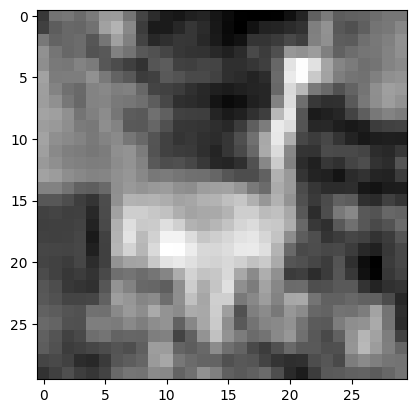

In [10]:
plt.imshow(output[0, 0].detach(), cmap="gray")
plt.show()

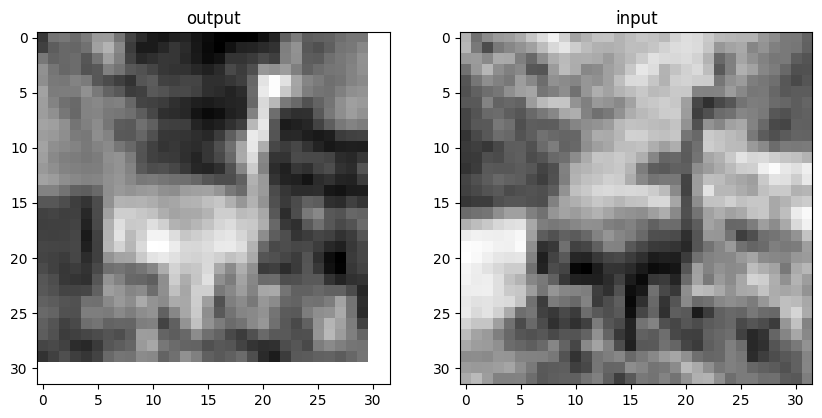

In [11]:
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')

plt.show()

Wait a minute. Let’s take a look a the size of output: it’s `torch.Size([1, 16, 30, 30])`. Huh; we lost a few pixels in the process.

How did that happen?

## Padding the boundary

By default, PyTorch will slide the convolution kernel within the input picture, getting `width - kernel_width + 1` horizontal and vertical positions.

In our case, specifying padding=1 when kernel_size=3 means i00 has an extra set
of neighbors above it and to its left, so that an output of the convolution can be computed even in the corner of our original image.

In [12]:
# Now with padding
conv = nn.Conv2d(3, 16, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 32, 32]))

## Detecting features

Let’s first zero out bias, just to remove any confounding factors, and then set
weights to a constant value so that each pixel in the output gets the mean of its neighbors.

In [13]:
with torch.no_grad():
  conv.bias.zero_()

with torch.no_grad():
  conv.weight.fill_(1.0 / 9.0)

let’s see the effect on our CIFAR image.

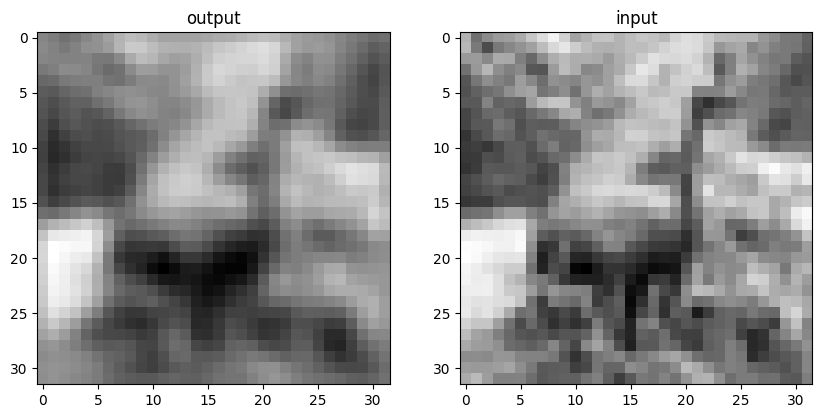

In [14]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.show()

Next, let’s try something different. The following kernel may look a bit mysterious at first:

In [15]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
  conv.weight[:] = torch.tensor([
    [-1.0, 0.0, 1.0],
    [-1.0, 0.0, 1.0],
    [-1.0, 0.0, 1.0]
  ])
  conv.bias.zero_()

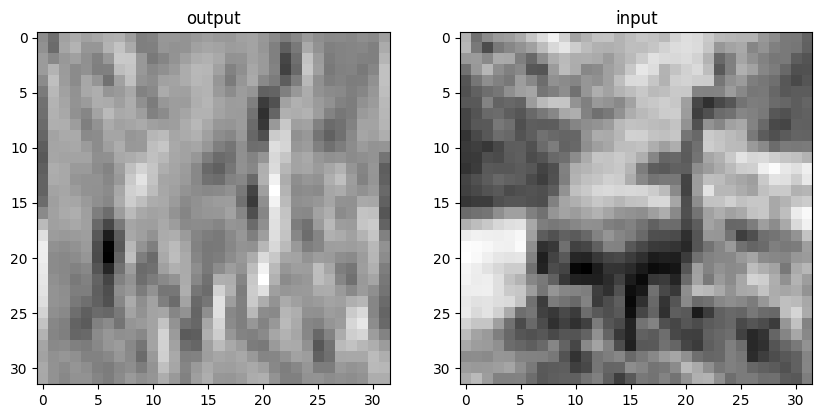

In [16]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip

plt.show()

## Max pooling

If we wish to downsample our image by half, we’ll want to use a size of 2.

Let’s verify that it works as expected directly on our input image:

In [17]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

## Putting it all together

Thinking back to the beginning of this chapter, we already know what we need to
do: turn the 8-channel 8 × 8 image into a 1D vector and complete our network with a set of fully connected layers:

In [19]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),

    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),

    # ...<1>

    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
)

Ignore the “something missing” comment for a minute.

Let’s first notice that the size of the linear layer is dependent on the expected size of the output of `MaxPool2d: 8 × 8 × 8 = 512`.

Let’s count the number of parameters for this small model:

In [20]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

We put the “Warning” note in the code for a reason. The model has zero chance of
running without complaining:

In [22]:
#model(img.unsqueeze(0))

```log
---------------------------------------------------------------------------
RuntimeError                              Traceback (most recent call last)
<ipython-input-21-9c784fd7714c> in <cell line: 1>()
----> 1 model(img.unsqueeze(0))

5 frames
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/linear.py in forward(self, input)
    112
    113     def forward(self, input: Tensor) -> Tensor:
--> 114         return F.linear(input, self.weight, self.bias)
    115
    116     def extra_repr(self) -> str:

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)
```

Admittedly, the error message is a bit obscure, but not too much so. We find references to linear in the traceback: looking back at the model, we see that only module that has to have a `512 × 32` tensor is `nn.Linear(512, 32)`, the first linear module after the last convolution block.

What’s missing there is the reshaping step from an 8-channel `8 × 8` image to a 512-element, 1D vector (1D if we ignore the batch dimension, that is). This could be achieved by calling view on the output of the last `nn.MaxPool2d`, but unfortunately, we don’t have any explicit visibility of the output of each module when we use `nn.Sequential`.

## Subclassing nn.Module

When we want to build models that do more complex things than just applying
one layer after another, we need to leave for something that gives us
nn.Sequential added flexibility. PyTorch allows us to use any computation in our model by subclassing nn.Module.

In order to subclass nn.Module, at a minimum we need to define a function
forward that takes the inputs to the module and returns the output. This is where we define our module’s computation.

With PyTorch, if we use standard torch operations, autograd will take care of the backward pass automatically; and indeed, an nn.Module never comes with a backward.

Typically, our computation will use other modules—premade like convolutions or
customized. To include these submodules, we typically define them in the constructor `__init__` and assign them to self for use in the forward function. They will, at the same time, hold their parameters throughout the lifetime of our module. Note that you need to call `super().__init__()` before you can do that (or PyTorch will remind you).

### Our network as an nn.Module

Let’s write our network as a submodule. To do so, we instantiate all the nn.Conv2d, nn.Linear, and so on that we previously passed to nn.Sequential in the constructor, and then use their instances one after another in forward:

In [ ]:
class Net(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.activation1 = nn.Tanh()
    self.pool1 = nn.MaxPool2d(2)

    self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
    self.activation2 = nn.Tanh()
    self.pool2 = nn.MaxPool2d(2)

    self.fc1 = nn.Linear(8 * 8 * 8, 32)
    self.activation3 = nn.Tanh()
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = self.pool1(self.activation1(self.conv1(x)))
    out = self.pool2(self.activation2(self.conv2(out)))
    # This reshape is what we were missing earlier.
    out = out.view(-1, 8 * 8 * 8)
    out = self.activation3(self.fc1(out))
    out = self.fc2(out)

    return out

Note that we leave the batch dimension as –1 in the call to view, since in principle we don’t know how many samples will be in the batch.

Recall that the goal of classification networks typically is to compress information in the sense that we start with an image with a sizable number of pixels and compress it into (a vector of probabilities of) classes. Two things about our architecture deserve some commentary with respect to this goal.

First, our goal is reflected by the size of our intermediate values generally
shrinking—this is done by reducing the number of channels in the convolutions, by reducing the number of pixels through pooling, and by having an output dimension lower than the input dimension in the linear layers. This is a common trait of classification networks. However, the reduction is achieved by pooling in the spatial resolution, but the number of channels increases (still resulting in a reduction in size). It seems that our pattern of fast information reduction works well with networks of limited depth and small images; but for deeper networks, the decrease is typically slower.

Second, in one layer, there is not a reduction of output size with regard to input size: the initial convolution. If we consider a single output pixel as a vector of 32 elements (the channels), it is a linear transformation of 27 elements (as a convolution of 3 channels × 3 × 3 kernel size)—only a moderate increase.

### How PyTorch keeps track of parameters and submodules

Interestingly, assigning an instance of nn.Module to an attribute in an nn.Module, automatically registers the module as a submodule.

In [ ]:
net = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

What happens here is that the call delves into all submodules assigned
parameters() as attributes in the constructor and recursively calls
on them. No matter parameters()  how nested the submodule, any can access the list of all child parameters. nn.Module By accessing their grad attribute, which has been populated by autograd, the optimizer will know how to change parameters to minimize the loss.

### The functional API

By “functional” here we mean “having no internal state”—in other words, “whose output value is solely and fully determined by the value input arguments.”

Indeed, torch.nn.functional provides many functions that work like the modules we find in nn. But instead of working on the input arguments and stored parameters like the module counterparts, they take inputs and parameters as arguments to the function call.

For instance, the functional counterpart of nn.Linear is nn.functional.linear,
which is a function that has signature linear(input, weight, bias=None). The
weight and bias parameters are arguments to the function.

In [ ]:
class Net(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(8 * 8 * 8, 32)
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
    out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
    out = out.view(-1, 8 * 8 * 8)
    out = torch.tanh(self.fc1(out))
    out = self.fc2(out)

    return out

Thus, the functional way also sheds light on what the nn.Module API is all about: a Module is a container for state in the forms of Parameters and submodules combined with the instructions to do a forward.

Whether to use the functional or the modular API is a decision based on style and taste. When part of a network is so simple that we want to use nn.Sequential, we’re in the modular realm. When we are writing our own forwards, it may be more natural to use the functional interface for things that do not need state in the form of parameters.

So now we can make our own nn.Module if we need to, and we also have the functional API for cases when instantiating and then calling an nn.Module is overkill.

Let’s double-check that our model runs, and then we’ll get to the training loop:

In [ ]:
model = Net()
model(img.unsqueeze(0))

tensor([[0.1720, 0.1507]], grad_fn=<AddmmBackward>)

We got two numbers! Information flows correctly. We might not realize it right now, but in more complex models, getting the size of the first linear layer right is sometimes a source of frustration.

## Training our convnet

We’re now at the point where we can assemble our complete training loop.

The core of our convnet is two nested loops: an outer one over the epochs and an inner one of the DataLoader that produces batches from our Dataset.

In each loop, we then have to

1. Feed the inputs through the model (the forward pass).
2. Compute the loss (also part of the forward pass).
3. Zero any old gradients.
4. Call loss.backward() to compute the gradients of the loss with respect to all
parameters (the backward pass).
5. Have the optimizer take a step in toward lower loss.

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
  # loop over the epochs, numbered from 1 to n_epochs rather than starting at 0
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    # Loops over dataset in the batches the data loader creates for us
    for imgs, labels in train_loader:
      # Feeds a batch through our model
      outputs = model(imgs)
      # and computes the loss we wish to minimize
      loss = loss_fn(outputs, labels)
      # After getting rid of the gradients from the last round
      optimizer.zero_grad()
      # performs the backward step. That is, we compute the gradients of all parameters we want the network to learn.
      loss.backward()
      # Updates the model
      optimizer.step()
      # Sums the losses
      loss_train += loss.item()
    if epoch == 1 or epoch % 10 == 0:
      # Divides by the length of the training data loader to get the average loss per batch.
      print("{} Epoch {}, Training loss {}".format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

We use the Dataset; wrap it into a DataLoader; instantiate our network,
an optimizer, and a loss function as before; and call our training loop.

Let’s run training for 100 epochs while printing the loss. Depending on your hardware, this may take 20 minutes or more to finish!

In [ ]:
# The DataLoader batches up the examples of our cifar2 dataset.
# Shuffling randomizes the order of the examples from the dataset.
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

# Instantiates our network …
model = Net()

# the stochastic gradient descent optimizer we have been working with
optimizer = optim.SGD(model.parameters(), lr=1e-2)
# and the cross entropy loss
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs=100, optimizer=optimizer, model=model, loss_fn=loss_fn, train_loader=train_loader)

2021-01-18 06:44:29.795152 Epoch 1, Training loss 0.5786836488991026
2021-01-18 06:45:00.125941 Epoch 10, Training loss 0.3248441396815002
2021-01-18 06:45:33.411864 Epoch 20, Training loss 0.2937185798481012
2021-01-18 06:46:06.318092 Epoch 30, Training loss 0.2710140582862174
2021-01-18 06:46:39.502667 Epoch 40, Training loss 0.2544134628905612
2021-01-18 06:47:12.510468 Epoch 50, Training loss 0.24225453652773693
2021-01-18 06:47:45.723106 Epoch 60, Training loss 0.2242267387118309
2021-01-18 06:48:18.840873 Epoch 70, Training loss 0.21108372443041223
2021-01-18 06:48:51.923412 Epoch 80, Training loss 0.19629904437976278
2021-01-18 06:49:25.295719 Epoch 90, Training loss 0.1811957617948769
2021-01-18 06:49:58.331065 Epoch 100, Training loss 0.16627288676181418


### Measuring accuracy

In order to have a measure that is more interpretable than the loss, we can take a look at our accuracies on the training and validation datasets.

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

In [ ]:
def validate(model, train_loader, val_loader):
  for name, loader in [("train", train_loader), ("val", val_loader)]:
    correct = 0
    total = 0
    # We do not want gradients here, as we will not want to update the parameters
    with torch.no_grad():
      for imgs, labels in loader:
        outputs = model(imgs)
        # Gives us the index of the highest value as output
        _, predicted = torch.max(outputs, dim=1)
        # Counts the number of examples, so total is increased by the batch size
        total += labels.shape[0]
        # Comparing the predicted class that had the maximum probability and the ground-truth labels, we first get a Boolean array. Taking the
        # sum gives the number of items in the batch where the prediction and ground truth agree.
        correct += int((predicted == labels).sum())
    print("Accuracy {}: {:.2f}".format(name, correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.89


This is quite a lot better than the fully connected model, which achieved only 79% accuracy. We about halved the number of errors on the validation set. Also, we used far fewer parameters. **This is telling us that the model does a better job of generalizing its task of recognizing the subject of images from a new sample, through locality and translation invariance.** We could now let it run for more epochs and see what performance we could squeeze out.

### Saving and loading our model

Since we’re satisfied with our model so far, it would be nice to actually save it, right?

In [ ]:
torch.save(model.state_dict(), data_path + "birds_vs_airplanes.pt")

The birds_vs_airplanes.pt file now contains all the parameters of model: that is, weights and biases for the two convolution modules and the two linear modules. So, no structure—just the weights. **This means when we deploy the model in production for our friend, we’ll need to keep the model class handy, create an instance, and then load the parameters back into it**:

In [ ]:
# We will have to make sure we don’t change the definition of Net between saving and later loading the model state.
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + "birds_vs_airplanes.pt"))

<All keys matched successfully>

### Training on the GPU

It is considered good style to move things to the GPU if one is available. A good pattern is to set the a variable device depending on torch.cuda.is_available:

In [ ]:
device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print(f"Training on device {device}.")

Training on device cuda.


Then we can amend the training loop by moving the tensors we get from the data
loader to the GPU by using the Tensor.to method. Note that the code is exactly like our first version at the beginning of this section except for the two lines moving the inputs to the GPU:

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
  # loop over the epochs, numbered from 1 to n_epochs rather than starting at 0
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    # Loops over dataset in the batches the data loader creates for us
    for imgs, labels in train_loader:
      # These two lines that move imgs and labels to the GPU device
      imgs = imgs.to(device=device)
      labels = labels.to(device=device)
      # Feeds a batch through our model
      outputs = model(imgs)
      # and computes the loss we wish to minimize
      loss = loss_fn(outputs, labels)
      # After getting rid of the gradients from the last round
      optimizer.zero_grad()
      # performs the backward step. That is, we compute the gradients of all parameters we want the network to learn.
      loss.backward()
      # Updates the model
      optimizer.step()
      # Sums the losses
      loss_train += loss.item()
    if epoch == 1 or epoch % 10 == 0:
      # Divides by the length of the training data loader to get the average loss per batch.
      print("{} Epoch {}, Training loss {}".format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

The same amendment must be made to the validate function. We can then instantiate our model, move it to device, and run it as before:

In [ ]:
# The DataLoader batches up the examples of our cifar2 dataset.
# Shuffling randomizes the order of the examples from the dataset.
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

# Moves our model (all parameters) to the GPU. If you forget to move either the model or the inputs to the GPU,
# you will get errors about tensors not being on the same device, because the PyTorch operators do not support mixing GPU and CPU inputs.
model = Net().to(device=device)

# the stochastic gradient descent optimizer we have been working with
optimizer = optim.SGD(model.parameters(), lr=1e-2)
# and the cross entropy loss
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs=100, optimizer=optimizer, model=model, loss_fn=loss_fn, train_loader=train_loader)

2021-01-18 06:50:11.825812 Epoch 1, Training loss 0.5637948120095927
2021-01-18 06:50:15.234206 Epoch 10, Training loss 0.33427952210994283
2021-01-18 06:50:19.000042 Epoch 20, Training loss 0.29963565527633496
2021-01-18 06:50:22.674725 Epoch 30, Training loss 0.2760529989839359
2021-01-18 06:50:26.467777 Epoch 40, Training loss 0.25198076560998417
2021-01-18 06:50:30.197634 Epoch 50, Training loss 0.2354876129965114
2021-01-18 06:50:33.860346 Epoch 60, Training loss 0.22041681185839282
2021-01-18 06:50:37.606905 Epoch 70, Training loss 0.20427968025587168
2021-01-18 06:50:41.547947 Epoch 80, Training loss 0.1874170883256159
2021-01-18 06:50:45.374443 Epoch 90, Training loss 0.17569316036192476
2021-01-18 06:50:49.334110 Epoch 100, Training loss 0.16044840719669487


Even for our small network here, we do see a sizable increase in speed. The advantage of computing on GPUs is more visible for larger models.

It is a bit more concise to instruct PyTorch to override the device
information when loading weights. This is done by passing the map_location keyword argument to torch.load:

In [ ]:
# We will have to make sure we don’t change the definition of Net between saving and later loading the model state.
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path + "birds_vs_airplanes.pt", map_location=device))

<All keys matched successfully>

## Model design

Plus images may not be our sole focus in the real world, where we have tabular
data, sequences, and text. The promise of neural networks is sufficient flexibility to solve problems on all these kinds of data given the proper architecture (that is, the interconnection of layers or modules) and the proper loss function.

PyTorch ships with a very comprehensive collection of modules and loss functions
to implement state-of-the-art architectures ranging from feed-forward components to long short-term memory (LSTM) modules and transformer networks (two very popular architectures for sequential data). Several models are available through PyTorch Hub or as part of torchvision and other vertical community efforts.

### Adding memory capacity: Width

Given our feed-forward architecture, there are a couple of dimensions we’d likely want to explore before getting into further complications. The first dimension is the width of the network: the number of neurons per layer, or channels per convolution.


We can make a model wider very easily in PyTorch. We just specify a larger number of output channels in the first convolution and increase the subsequent layers accordingly, taking care to change the forward function to reflect the fact that we’ll now have a longer vector once we switch to fully connected layers:

In [ ]:
class WideNetwork(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(16 * 8 * 8, 32)
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
    out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
    out = out.view(-1, 16 * 8 * 8)
    out = torch.tanh(self.fc1(out))
    out = self.fc2(out)

    return out

If we want to avoid hardcoding numbers in the definition of the model, we can easily pass a parameter to init and parameterize the width, taking care to also parameterize the call to view in the forward function.

In [ ]:
class WideNetwork(nn.Module):

  def __init__(self, n_channel=32):
    super().__init__()
    self.n_channel = n_channel
    self.conv1 = nn.Conv2d(3, n_channel, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(n_channel, n_channel // 2, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(8 * 8 * n_channel // 2, 32)
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
    out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
    out = out.view(-1, 8 * 8 * self.n_channel // 2)
    out = torch.tanh(self.fc1(out))
    out = self.fc2(out)

    return out

In [ ]:
# The DataLoader batches up the examples of our cifar2 dataset.
# Shuffling randomizes the order of the examples from the dataset.
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

# Moves our model (all parameters) to the GPU. If you forget to move either the model or the inputs to the GPU,
# you will get errors about tensors not being on the same device, because the PyTorch operators do not support mixing GPU and CPU inputs.
model = WideNetwork().to(device=device)

# the stochastic gradient descent optimizer we have been working with
optimizer = optim.SGD(model.parameters(), lr=1e-2)
# and the cross entropy loss
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs=100, optimizer=optimizer, model=model, loss_fn=loss_fn, train_loader=train_loader)

2021-01-18 06:59:43.410872 Epoch 1, Training loss 0.5373456705907348
2021-01-18 06:59:47.234313 Epoch 10, Training loss 0.3100430370326255
2021-01-18 06:59:51.336249 Epoch 20, Training loss 0.26951973007363117
2021-01-18 06:59:55.561712 Epoch 30, Training loss 0.23577301242169302
2021-01-18 06:59:59.836520 Epoch 40, Training loss 0.20491675875938622
2021-01-18 07:00:04.062203 Epoch 50, Training loss 0.17928042566510521
2021-01-18 07:00:08.318892 Epoch 60, Training loss 0.15883874463712333
2021-01-18 07:00:12.615775 Epoch 70, Training loss 0.13749011921559928
2021-01-18 07:00:16.843254 Epoch 80, Training loss 0.1192706318892491
2021-01-18 07:00:20.938492 Epoch 90, Training loss 0.09973475405839598
2021-01-18 07:00:25.133886 Epoch 100, Training loss 0.08441405498962494


The numbers specifying channels and features for each layer are directly related to the number of parameters in a model; all other things being equal, they increase the capacity of the model.

In [ ]:
sum(p.numel() for p in model.parameters())

38386

The greater the capacity, the more variability in the inputs the model will be able to manage; but at the same time, the more likely overfitting will be, since the model can use a greater number of parameters to memorize unessential aspects of the input. We already went into ways to combat overfitting, the best being increasing the sample size or, in the absence of new data, augmenting existing data through artificial modifications of the same data.

### Helping our model to converge and generalize: Regularization